In [1]:
import pandas as pd
import numpy as np
import os
from collections import OrderedDict

import torch
from torch import nn, optim
import torch.nn.functional as F

from tqdm import tqdm

# Pre-process DRF Files

In [93]:
def generate_master_df(path, num_races=3):
    '''
        Generate the master dataframe from which we will create our training/testing data
        
        Args:
            path (string): Path to directory containing DRF files to parse
            num_races (int): Number of races to use in each sequence (how many races back
                             are we looking?)
        
        Returns: Dataframe containing all data from each DRF concatted together
    '''
    # Cap num_races
    num_races = min(num_races, 9) # Only have max of 9 prev race's data
    
    # Get all DRF files in data directory
    filenames = [path+file for file in os.listdir(path) if file.endswith(".DRF")]
    
    # Iterate through each file and concat data to master df
    master_df = None
    for ii, file in tqdm(enumerate(filenames)): 
        if ii == 0:
            # First pass through just create master df
            df = pd.read_csv(file, header=None)
            master_df = slice_df(df, num_races)
        else:
            # All other passes, append sliced dataframe to master
            df = pd.read_csv(file, header=None)
            df = slice_df(df, num_races)
            master_df = master_df.append(df, ignore_index=True)
            
    # Drop all rows containing NaN values (these horses didn't have enough prev races)
    master_df = master_df.dropna().reset_index().drop(['index'], axis=1)
    # Derive lifetime finish metrics
    master_df = derive_recent_finishes(master_df, num_races)
    # Clean data and return
    return clean_data(master_df, num_races)

def slice_df(df, num_races=3):
    '''
        This will take the 1400 field dataframe created from parsing input file CSVs 
        and cut it down to only include information relevant to training the network
        
        Args:
            df (pd.DataFrame): the unedited, 1400 field dataframe
            num_races (int): the number of races into the past we are gathering data for
            
        Returns:
            pd.DataFrame containing only fields relevant to network training
    '''
    # Define columns to grab
    column_ids = OrderedDict({
        'horse_age': (45,46),
        'horse_name': (44,45),
        'lifetime_starts': (96, 97),
        'lifetime_wins': (97, 98),
        'lifetime_places': (98, 99),
        'lifetime_shows': (99, 100),
        'days_since_prev_race': (265, 265+num_races),
        'distance': (315, 315+num_races),
        'num_entrants': (345, 346),#345+num_races),
        'post_position': (355, 355+num_races),
        'weight': (505, 505+num_races),
        'winner_name': (405, 405+num_races),
        'place_name': (415, 415+num_races),
        'show_name': (425, 425+num_races),
        'prev_finish_pos': (615, 615+num_races),
        'label': (1035, 1036) # Finish time of current race
    })

    # Select all of our column ranges
    rng = []
    col_names = []
    for k,v in column_ids.items():
        # Append range to rng -- special case for single field
        if v[1] - v[0] == 1:
            rng += [v[0]]
            col_names.append(k)
        else:
            # Handle column ranges
            rng += range(v[0],v[1])
            for ii in range(v[0], v[1]):
                col_names.append('{}_{}'.format(k, ii-v[0]))

    # Slice df on columns
    ret = df.loc[:, rng]
    ret.columns = col_names
    return ret

def derive_recent_finishes(df, num_races=3):
    '''
        Derive recent win/place/show counts. 
        
        Args:
            df (pd.DataFrame): DataFrame containing all fields necessary for derivations
            num_races (int): the number of races into the past we are looking
            
        Returns:
            pd.DataFrame containing all data in df with the addition of recent finish fields
    '''
    drop_columns = []
    
    # Initialize recent finish fields
    df['recent_wins'] = 0
    df['recent_places'] = 0
    df['recent_shows'] = 0
    
    for race in range(num_races):        
        # Determine if a horse got win/place/show for previous races
        win_col = 'winner_name_{}'.format(race)
        place_col = 'place_name_{}'.format(race)
        show_col = 'show_name_{}'.format(race)
        
        # Boolean columns for if a horse won race_x or not
        horse_won_col = 'horse_won_{}'.format(race)
        horse_placed_col = 'horse_placed_{}'.format(race)
        horse_showed_col = 'horse_showed_{}'.format(race)

        df[horse_won_col] = df[win_col] == df['horse_name']
        df[horse_placed_col] = df[place_col] == df['horse_name']
        df[horse_showed_col] = df[show_col] == df['horse_name']


        # If horse won/placed/showed, increment stats accordingly. For Race_0, we want to calc
        # lifetime stats, since this is the race we are training on. Won't count finishes of 
        # Race_0 in the 'recent' columns, since for the sake of training Race_0 is our current
        # race.
        if race == 0:
            df['lifetime_starts'] = df['lifetime_starts'] - 1
            df.loc[df[horse_won_col] == True, 'lifetime_wins'] = df['lifetime_wins'] - 1
            df.loc[df[horse_placed_col] == True, 'lifetime_places'] = df['lifetime_places'] - 1
            df.loc[df[horse_showed_col] == True, 'lifetime_shows'] = df['lifetime_shows'] - 1
        else:
            df.loc[df[horse_won_col] == True, 'recent_wins'] = df['recent_wins'] + 1
            df.loc[df[horse_placed_col] == True, 'recent_places'] = df['recent_places'] + 1
            df.loc[df[horse_showed_col] == True, 'recent_shows'] = df['recent_shows'] + 1

        # Append intermediate columns to drop list
        drop_columns += [horse_won_col, horse_placed_col, horse_showed_col, win_col, place_col, show_col, 'horse_name']
            
    # Drop unnecessary columns
    df = df.drop(drop_columns, axis=1)    
        
    return df

def clean_data(df, num_races=3):
    '''
        Clean the data of any outliers or incorrect values
    '''
    # Drop horses that didn't finish one of their previous races (finish == x or q)
    prev_finish_cols = ['prev_finish_pos_{}'.format(race) for race in range(num_races)]
    for col in prev_finish_cols:
        df[col] = df[col].str.lower()
        df = df.loc[df[col] != 'x']
        df = df.loc[df[col] != 'q']
        
    # Drop prev finish columns
    df = df.drop(prev_finish_cols, axis=1)
    
    # Drop horses whose finish time is 0 or negative
    df = df.loc[df['label'] > 0]
    
    # Drop horses whose post position is 0
    post_pos_cols = ['post_position_{}'.format(race) for race in range(num_races)]
    for col in post_pos_cols:
        df = df.loc[df[col] > 0]
        
    # Drop horses who have a negative lifetime stat (think these are a result of dqs)
    df = df.loc[df['lifetime_shows'] >= 0]
    df = df.loc[df['lifetime_places'] >= 0]
    df = df.loc[df['lifetime_wins'] >= 0]
        
    # Drop horses who have negative distance values for their races (bad data)
    distance_cols = ['distance_{}'.format(race) for race in range(num_races)]
    for col in distance_cols:
        df = df.loc[df[col] >= 0]
    
    return df

In [95]:
# Pre-process input files to generate master dataframe
#pd.set_option('display.max_columns', None) # Remove
past_races_included = 3
master_df = generate_master_df('./input_files/', num_races=past_races_included)
master_df.head(5)

print(master_df.min())
print(master_df.max())

419it [00:40,  8.67it/s]


lifetime_shows              0.00
lifetime_places             0.00
horse_age                   4.00
weight_0                  107.00
weight_1                  106.00
weight_2                  106.00
lifetime_wins               0.00
days_since_prev_race_0      1.00
days_since_prev_race_1      1.00
days_since_prev_race_2      3.00
post_position_0             1.00
post_position_1             1.00
post_position_2             1.00
label                       6.57
num_entrants                3.00
distance_0                100.00
distance_1                100.00
distance_2                100.00
lifetime_starts             3.00
recent_wins                 0.00
recent_places               0.00
recent_shows                0.00
dtype: float64
lifetime_shows              28.0
lifetime_places             25.0
horse_age                   14.0
weight_0                   165.0
weight_1                   165.0
weight_2                   169.0
lifetime_wins               26.0
days_since_prev_race_0    10

In [96]:
# Generate data and labels for dataset
master_data = master_df.drop(['label'], axis=1)
master_labels = master_df['label']

# Create Dataloader

In [113]:
from sklearn.utils import shuffle as df_shuffle

def dataloader(data, labels, shuffle=True):
    if shuffle:
            df = data.copy()
            df['label'] = labels
            df = df_shuffle(df)
            labels = df['label']
            data = df.drop(['label'], axis=1)
            
    # Turn data and label into tensor
    for ii in range(len(data)):        
        yield torch.tensor(data.iloc[ii]), torch.tensor(labels.iloc[ii])

In [108]:
# Test dataloader
sample_data, sample_label = next(iter(dataloader(master_data, master_labels)))
print(sample_data, sample_label)

tensor([1.0000e+00, 0.0000e+00, 1.3000e+01, 1.1600e+02, 1.1800e+02, 1.2100e+02,
        1.0000e+00, 2.6000e+01, 1.4000e+01, 1.6000e+01, 8.0000e+00, 6.0000e+00,
        2.0000e+00, 1.2000e+01, 1.3200e+03, 1.4300e+03, 1.1000e+03, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00]) tensor(71.8100)


# Create Training/Test Datasets

In [114]:
train_prop = 0.8 # Proportion of training data to testing data
train_end_idx = int(len(master_data) * 0.8)

train_data = master_data[:train_end_idx]
train_labels = master_labels[:train_end_idx]

test_data = master_data[train_end_idx:]
test_labels = master_labels[train_end_idx:]

# Standardize Test and Training Sets

In [115]:
# Will subtract mean of each column from each element in that column, then divide difference by std of column
train_data = (train_data.subtract(train_data.mean()))/train_data.std()
test_data = (test_data.subtract(test_data.mean()))/test_data.std()

print((np.mean(train_data), np.std(train_data)), (np.mean(test_data), np.std(test_data)))

(lifetime_shows            2.524265e-15
lifetime_places          -1.053379e-15
horse_age                 4.133590e-15
weight_0                  1.801594e-15
weight_1                  3.909027e-15
weight_2                 -2.081484e-15
lifetime_wins            -2.324268e-16
days_since_prev_race_0   -2.110849e-17
days_since_prev_race_1   -2.733783e-18
days_since_prev_race_2    5.480160e-17
post_position_0          -4.531322e-17
post_position_1           1.657993e-16
post_position_2           3.817835e-16
num_entrants             -4.092197e-16
distance_0                6.518076e-16
distance_1               -2.462592e-15
distance_2               -5.506502e-15
lifetime_starts          -1.136719e-15
recent_wins               1.525942e-15
recent_places             3.818573e-16
recent_shows              7.332682e-17
dtype: float64, lifetime_shows            0.999972
lifetime_places           0.999972
horse_age                 0.999972
weight_0                  0.999972
weight_1                

# Define the Model

In [121]:
input_features = train_data.shape[1]
output_size = 1
drop_prob = 0.2

model = nn.Sequential(
    nn.Linear(input_features, 512),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(drop_prob),
    nn.Linear(256, output_size)
)

print(model)

Sequential(
  (0): Linear(in_features=21, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=256, out_features=1, bias=True)
)


# Train Model

In [122]:
# Use GPU if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define Training/Validation Loop
epochs = 5
lr = 0.003
print_every = 500
clip = 5

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

training_losses = [x for x in range(epochs)]
validation_losses = [x for x in range(epochs)]

for epoch in range(epochs):
    print('Starting Epoch {}'.format(epoch+1))
    entries_processed = 0
    
    # Begin Training Loop
    train_losses = []
    val_losses = []
    for data, label in dataloader(train_data, train_labels):
        entries_processed += 1
        
        # Set tensors to correct device
        data, label = data.to(device), label.to(device)
        
        # Zero out gradients
        model.zero_grad()
        
        # Perform pass through network
        train_out = model(data)
        
        # Calculate Loss and perform backprop -- clip gradients if necessary
        train_loss = criterion(train_out, label)
        train_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Log Loss
        train_losses.append(train_loss.item())
    
        # Take optimizer step
        optimizer.step()
        
        if entries_processed % print_every == 0:
            # Validation loop
            model.eval()
            for data, label in dataloader(test_data, test_labels):
                # Set tensors to correct device
                data, label = data.to(device), label.to(device)
                
                # Generate prediction
                val_out = model(data)
                
                # Calculate and log loss
                val_loss = criterion(val_out, label)
                val_losses.append(val_loss.item())
                
                # Set back to training mode
                model.train()
                
            # Print Metrics
            print(
                'Epoch: {}/{}...'.format(epoch+1, epochs),
                'Entries Processed: {}...'.format(entries_processed),
                'Training Loss: {:.6f}...'.format(np.mean(train_losses)),
                'Validation Loss: {:.6f}...'.format(np.mean(val_losses))
                 )
            
        # Log Epoch-level metrics
        training_losses[epoch] = np.mean(train_losses)
        validation_losses[epoch] = np.mean(val_losses)

Starting Epoch 1


/Users/nate/anaconda3/envs/julie-stav-ws/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nate/anaconda3/envs/julie-stav-ws/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1/5... Entries Processed: 500... Training Loss: 730.950640... Validation Loss: 390.232156...
Epoch: 1/5... Entries Processed: 1000... Training Loss: 488.303281... Validation Loss: 355.348823...
Epoch: 1/5... Entries Processed: 1500... Training Loss: 385.937060... Validation Loss: 297.536251...
Epoch: 1/5... Entries Processed: 2000... Training Loss: 339.792819... Validation Loss: 261.529726...
Epoch: 1/5... Entries Processed: 2500... Training Loss: 307.208981... Validation Loss: 271.416388...
Epoch: 1/5... Entries Processed: 3000... Training Loss: 283.802915... Validation Loss: 254.921883...
Epoch: 1/5... Entries Processed: 3500... Training Loss: 261.844112... Validation Loss: 243.719173...
Epoch: 1/5... Entries Processed: 4000... Training Loss: 245.284117... Validation Loss: 231.711739...
Epoch: 1/5... Entries Processed: 4500... Training Loss: 231.261359... Validation Loss: 218.328560...
Epoch: 1/5... Entries Processed: 5000... Training Loss: 223.010624... Validation Loss: 218.9

Epoch: 3/5... Entries Processed: 5000... Training Loss: 98.536232... Validation Loss: 114.656274...
Epoch: 3/5... Entries Processed: 5500... Training Loss: 98.140799... Validation Loss: 112.851585...
Epoch: 3/5... Entries Processed: 6000... Training Loss: 98.085527... Validation Loss: 113.711797...
Epoch: 3/5... Entries Processed: 6500... Training Loss: 98.461599... Validation Loss: 113.521406...
Epoch: 3/5... Entries Processed: 7000... Training Loss: 99.025420... Validation Loss: 114.964190...
Epoch: 3/5... Entries Processed: 7500... Training Loss: 98.246047... Validation Loss: 113.732871...
Epoch: 3/5... Entries Processed: 8000... Training Loss: 97.499320... Validation Loss: 113.236741...
Epoch: 3/5... Entries Processed: 8500... Training Loss: 96.877611... Validation Loss: 113.382418...
Epoch: 3/5... Entries Processed: 9000... Training Loss: 96.966767... Validation Loss: 113.355272...
Epoch: 3/5... Entries Processed: 9500... Training Loss: 96.984445... Validation Loss: 115.175137...


Epoch: 5/5... Entries Processed: 10000... Training Loss: 83.279342... Validation Loss: 108.319876...
Epoch: 5/5... Entries Processed: 10500... Training Loss: 84.734455... Validation Loss: 106.512677...
Epoch: 5/5... Entries Processed: 11000... Training Loss: 84.366834... Validation Loss: 106.664672...
Epoch: 5/5... Entries Processed: 11500... Training Loss: 84.634107... Validation Loss: 108.138689...
Epoch: 5/5... Entries Processed: 12000... Training Loss: 84.500570... Validation Loss: 106.852010...
Epoch: 5/5... Entries Processed: 12500... Training Loss: 84.413186... Validation Loss: 105.872274...
Epoch: 5/5... Entries Processed: 13000... Training Loss: 84.346364... Validation Loss: 109.877581...
Epoch: 5/5... Entries Processed: 13500... Training Loss: 84.100770... Validation Loss: 108.829371...
Epoch: 5/5... Entries Processed: 14000... Training Loss: 84.310773... Validation Loss: 108.112888...
Epoch: 5/5... Entries Processed: 14500... Training Loss: 84.067778... Validation Loss: 107.

# Plot Performance

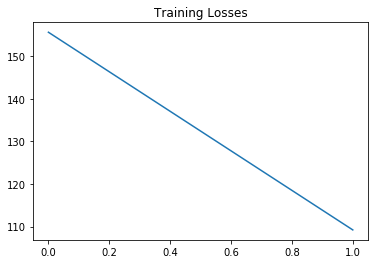

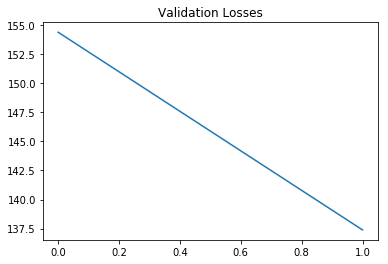

In [119]:
import matplotlib.pyplot as plt

# Plot training losses
plt.title('Training Losses')
plt.plot(training_losses)
plt.show()

# Plot Validation Losses
plt.title('Validation Losses')
plt.plot(validation_losses)
plt.show() 

# Save the Model

In [124]:
torch.save(model, './models/linear-model-5e.pth')

# Load and Test Model

In [125]:
loaded_model = torch.load('./models/linear-model-5e.pth')

# Evaluate model
loaded_model = loaded_model.to(device)
model.eval()
element = 6969

data = torch.tensor(train_data.iloc[element]).to(device)
label = torch.tensor(train_labels.iloc[element]).to(device)

prediction = loaded_model(data)
loss = criterion(prediction, label)

print(prediction, label, loss.item())

tensor([69.9675], grad_fn=<AddBackward0>) tensor(72.6600) 7.249541282653809
